# Hierarchical HMM: Chords & Song Sections

## Data Cleaning & Augmentation
Simplifying chords down to 42: base note (A-G) + accidental + major/minor(dim).

In [129]:
import pandas as pd

notes = ["A", "B", "C", "D", "E", "F", "G"]
accs = ["b", "s", ""]
all_notes_list = [note + acc for note in notes for acc in accs]

def simplify_chord(chord: str) -> str:
    """
    Removes chord quality from a chord.
    """
    for note in all_notes_list:
        if not chord.startswith(note):
            continue

        suffix = chord.removeprefix(note)
        if suffix.startswith("min") or suffix.startswith("dim"):
            return note + "min"
        else:
            return note

    if chord == "sC":
        return "Cs"

    return ""


def expand_sections(tokens):
    """
    Given token list ["<intro_1>", "C", "<verse_1>", "F", "C", "G7", ...]
    Returns list of replicated section labels ["intro", "intro", "verse", "verse", "verse", "verse", ...]
    """
    section_labels = []
    current_section = None

    for tok in tokens:
        if tok.startswith("<") and tok.endswith(">"):
            raw = tok[1:-1] # drop <>
            current_section = raw.split("_")[0] # intro_1 --> intro
        else:
            section_labels.append(current_section) # replicate current section label if it's a chord
    return section_labels


##### Main Processing #####

df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv", usecols=["chords", "main_genre"])

# filter only pop songs
pop_df = df[df["main_genre"] == "pop"].copy()
pop_df["tokens"] = pop_df["chords"].str.split(" ")

# remove all songs with no section tags
pop_df = pop_df[
    pop_df["chords"].apply(
        lambda tokens: any(token.startswith("<") for token in tokens)
    )
].copy()

print("After filtering:", len(pop_df))  # 55k

pop_df["simple_chords"] = pop_df["tokens"].apply(
    lambda toks: [simplify_chord(tok) for tok in toks if not tok.startswith("<")]
)

pop_df["sections"] = pop_df["tokens"].apply(expand_sections)

# sanity check
assert all(
    len(c) == len(s)
    for c, s in zip(pop_df["simple_chords"], pop_df["sections"])
), "Mismatched chord-section lengths"

print(pop_df.head())

/var/folders/c8/zh68_k6j30l283wd6sjg39280000gn/T/ipykernel_69655/3823867086.py:46: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv", usecols=["chords", "main_genre"])


After filtering: 55641
                                              chords main_genre  \
0  <intro_1> C <verse_1> F C E7 Amin C F C G7 C F...        pop   
4  <intro_1> C <verse_1> G C G C <chorus_1> F Dmi...        pop   
6  <intro_1> G Bmin Amin D G Bmin <verse_1> Amin ...        pop   
7  <intro_1> Fsmin Fsno3d Bno3d E/B Fsno3d Bno3d ...        pop   
8  <chorus_1> C Amin Dmin G C G Amin Dmin G C <ve...        pop   

                                              tokens  \
0  [<intro_1>, C, <verse_1>, F, C, E7, Amin, C, F...   
4  [<intro_1>, C, <verse_1>, G, C, G, C, <chorus_...   
6  [<intro_1>, G, Bmin, Amin, D, G, Bmin, <verse_...   
7  [<intro_1>, Fsmin, Fsno3d, Bno3d, E/B, Fsno3d,...   
8  [<chorus_1>, C, Amin, Dmin, G, C, G, Amin, Dmi...   

                                       simple_chords  \
0  [C, F, C, E, Amin, C, F, C, G, C, F, C, E, Ami...   
4  [C, G, C, G, C, F, Dmin, G, Dmin, G, C, G, C, ...   
6  [G, Bmin, Amin, D, G, Bmin, Amin, D, G, Emin, ...   
7  [Fsmin, Fs

In [112]:
num_chords = pop_df['simple_chords'].str.len()
print(num_chords.mean())

84.27549828363976


In [130]:
# Split train & test
pop_df_train = pop_df.iloc[:50000]
pop_df_test = pop_df.iloc[50000:]

In [131]:
# Extract chords by section label -> one dataframe per label
all_sections = set(
    tag
    for tags in pop_df_train["sections"]
    for tag in tags
)
print("Observed sections:", str(all_sections))
print(len(all_sections))

# section -> df with column "chords"
section_dfs = {}
for section in all_sections:
    song_chords_per_sect = []

    for chords, secs in zip(pop_df_train["simple_chords"], pop_df_train["sections"]):
        # indices where the section appears
        idxs = [i for i, s in enumerate(secs) if s == section]

        # don't record in df if the song doesn't have the section
        if not idxs:
            continue

        # extract the chords at these indices
        seq = [chords[i] for i in idxs]

        song_chords_per_sect.append(seq)

    section_dfs[section] = pd.DataFrame({"chords": song_chords_per_sect})


for section in all_sections:
    print(f"\nSection: {section}")
    print(section_dfs[section].head())
    print("Num rows:", len(section_dfs[section]))

Observed sections: {'intro', 'verse', 'interlude', 'chorus', 'solo', 'outro', 'bridge', 'instrumental'}
8

Section: intro
                                  chords
0                                    [C]
1                                    [C]
2            [G, Bmin, Amin, D, G, Bmin]
3  [Fsmin, Fs, B, E, Fs, B, E, Fsmin, B]
4                           [C, C, C, C]
Num rows: 33084

Section: verse
                                              chords
0  [F, C, E, Amin, C, F, C, G, C, F, C, E, Amin, ...
1                           [G, C, G, C, G, C, G, C]
2  [Amin, D, G, Emin, Amin, D, G, Emin, Amin, D, ...
3  [Dmin, C, Dmin, C, Amin, Dmin, G, Dmin, C, Dmi...
4   [G, D, Emin, D, Emin, Amin, D, G, G, C, C, Amin]
Num rows: 47106

Section: interlude
                                              chords
0                  [F, G, Emin, Amin, Dmin, G, C, G]
1  [C, F, G, Cmin, G, Cmin, D, G, Ab, Cmin, G, Cmin]
2  [E, E, B, E, E, E, A, B, E, E, B, E, E, A, B, ...
3  [Amin, G, C, Amin, G, C, G, Ami

In [132]:
# Add EOS section label
def add_EOS(tokens):
    return tokens + ["EOS"]

pop_df_train.loc[:, 'sections'] = pop_df_train['sections'].apply(add_EOS)

# Learning
Compute n-gram counts using CountVectorizer library

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def count_n_grams(data, n: int = 1) -> pd.DataFrame:
    word_vectorizer = CountVectorizer(
        ngram_range=(1, n),
        analyzer="word",
        token_pattern=r"(?u)\b\w+\b",
        lowercase=False,
    )

    sparse_matrix = word_vectorizer.fit_transform(
        data.map(lambda chords: " ".join(chords))
    )

    frequencies = sum(sparse_matrix).toarray()[0]

    df_all = pd.DataFrame(
        frequencies,
        index=word_vectorizer.get_feature_names_out(),
        columns=["count"],
    )

    return df_all.groupby(by=lambda chords: len(chords.split(" ")))

In [ ]:
import itertools

# Calculate transition matrix probabilities
# alpha is additive smoothing
def compute_unigram_prob(n_gram_counts, vocab, alpha=1.0):
    unigram = n_gram_counts.get_group(1).copy()
    unigram = unigram.reindex(vocab, fill_value=0)
    vocab_size = len(vocab)
    total_count = unigram["count"].sum()

    probs = (unigram["count"] + alpha) / (total_count + alpha * vocab_size)
    df = pd.DataFrame([probs.values], 
                      index=[""],
                      columns=vocab)
    return df

def compute_ngram_prob(n_gram_counts, vocab, n : int = 2, alpha=1.0):
    ngram = n_gram_counts.get_group(n).copy()

    ngram["evidence"] = ngram.index.map(lambda s: " ".join(s.split()[:-1]))
    ngram["next"] = ngram.index.map(lambda s: s.split()[-1])
    
    # generate all possible (n-1)-length chord sequeneces
    all_evidence_seq = [" ".join(evidence) for evidence in itertools.product(vocab, repeat=(n - 1))]
    full_index = pd.MultiIndex.from_product([all_evidence_seq, vocab], names=["evidence", "next"])

    # reindex to (vocab_size^(n-1), n)
    ngram = ngram.set_index(["evidence", "next"])
    ngram = ngram.reindex(full_index, fill_value=0)

    # compute probs
    evidence_counts = ngram["count"].groupby(level="evidence").transform("sum")
    vocab_size = len(vocab)
    ngram["prob"] = (ngram["count"] + alpha) / (evidence_counts + alpha * vocab_size)

    # 2d df transition matrix
    return ngram["prob"].unstack(fill_value=0.0)

Compute n-gram counts for section labels

In [ ]:
# Sections

n = 2 # S_t+1 only depends on S_t

pop_sections = pop_df_train['sections']
n_gram_cnts = count_n_grams(pop_sections, n)
for key, _ in n_gram_cnts:
    print(n_gram_cnts.get_group(key).sort_values(by='count'), "\n\n")

                count
solo            28782
instrumental    78982
interlude       79954
EOS            111282
outro          237375
bridge         300348
intro          306352
verse         1775400
chorus        1881980 


                     count
solo intro               3
solo instrumental        6
outro interlude         10
outro bridge            13
instrumental solo       16
...                    ...
outro outro         212670
intro intro         268478
bridge bridge       272191
verse verse        1665286
chorus chorus      1759010

[73 rows x 1 columns] 




In [ ]:
all_sections = list(set(
    tag
    for tags in pop_df_train["sections"]
    for tag in tags
))
print("All sections:", str(all_sections))
print(len(all_sections))

# Section unigram probs
unigram_probs_sec = compute_unigram_prob(n_gram_cnts, all_sections)
print(unigram_probs_sec.shape)
unigram_probs_sec

All sections: ['intro', 'verse', 'EOS', 'interlude', 'chorus', 'solo', 'outro', 'bridge', 'instrumental']
9
(1, 9)


,intro,verse,EOS,interlude,chorus,solo,outro,bridge,instrumental
,0.063817,0.369839,0.023182,0.016656,0.392041,0.005996,0.049449,0.062567,0.016453


In [73]:
# Section bigram probs
bigram_probs_sec = compute_ngram_prob(n_gram_cnts, all_sections, n=2)
print(bigram_probs_sec.shape)
bigram_probs_sec

(9, 9)


next,EOS,bridge,chorus,instrumental,interlude,intro,outro,solo,verse
evidence,,,,,,,,,
EOS,0.999856,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
bridge,0.005147,0.906228,0.061610,0.002720,0.002161,0.000173,0.008254,0.001059,0.012648
chorus,0.012255,0.010614,0.934655,0.003682,0.003537,0.000291,0.009201,0.000950,0.024814
instrumental,0.008533,0.016090,0.029953,0.872859,0.000886,0.000392,0.011875,0.000215,0.059197
interlude,0.005515,0.011680,0.029088,0.001013,0.877193,0.000263,0.008341,0.001126,0.065780
intro,0.002729,0.000473,0.011447,0.000659,0.000607,0.876348,0.000558,0.000222,0.106956
outro,0.100849,0.000059,0.000265,0.000493,0.000046,0.001571,0.895894,0.000114,0.000708
solo,0.011080,0.011323,0.033899,0.000243,0.001111,0.000139,0.008232,0.902643,0.031329
verse,0.002720,0.003038,0.052178,0.000987,0.001212,0.000050,0.001592,0.000248,0.937974


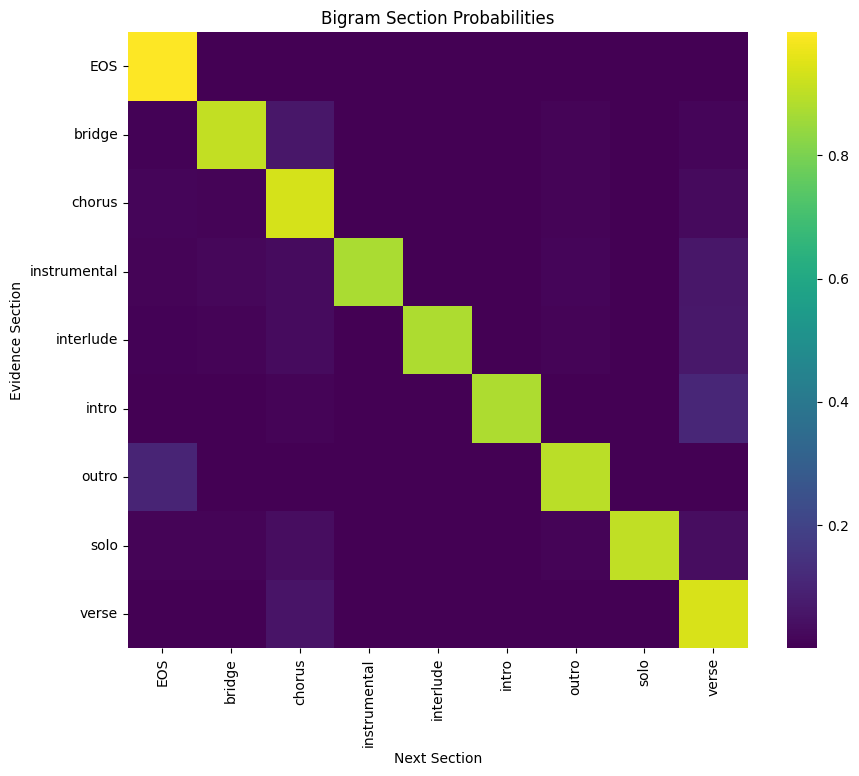

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(bigram_probs_sec, cmap="viridis")
plt.title("Bigram Section Probabilities")
plt.xlabel("Next Section")
plt.ylabel("Evidence Section")
plt.show()

Compute n-gram counts for chords

In [26]:
# Vocabulary of all possible chords (flats consolidated with sharps)
notes = ["A", "B", "C", "D", "E", "F", "G"]
accs = ["b", "s", ""]
third = ["", "min"]
all_chords = [note + acc + t for note in notes for acc in accs for t in third]

In [51]:
n = 4
section_n_gram_counts = {} # index: section_n_gram_counts["intro"][1]
section_n_gram_probs = {}

for section, section_df in section_dfs.items():
    # for song chords in each section, get n_gram counts
    chord_series = section_df["chords"]

    counts_df = count_n_grams(chord_series, n)
    section_n_gram_counts[section] = counts_df

    # compute transition probabilities for each n
    section_n_gram_probs[section] = {}

    # unigram
    unigram_probs = compute_unigram_prob(counts_df, all_chords)
    section_n_gram_probs[section][1] = unigram_probs

    # bigrams
    if n >= 2:
        bigram_probs = compute_ngram_prob(counts_df, all_chords, n=2)
        section_n_gram_probs[section][2] = bigram_probs

    # trigrams
    if n >= 3:
        trigram_probs = compute_ngram_prob(counts_df, all_chords, n=3)
        section_n_gram_probs[section][3] = trigram_probs

    # 4-gram
    if n >= 4:
        trigram_probs = compute_ngram_prob(counts_df, all_chords, n=4)
        section_n_gram_probs[section][4] = trigram_probs

# sanity check
print("Sections processed:", list(section_n_gram_counts.keys()))

Sections processed: ['intro', 'verse', 'interlude', 'chorus', 'solo', 'outro', 'bridge', 'instrumental']


In [94]:
# Sample calls
chorus_unigrams = section_n_gram_probs["chorus"][1]
bridge_trigrams = section_n_gram_counts["bridge"].get_group(3)

# Inference
Probabilistic method

In [81]:
import numpy as np

# def deterministic_inference(evidence):
#     # evidence: string of n-1 space-separated chords
    
#     n = len(evidence.split()) + 1
#     ngram_probs = unigram_probs if n == 1 else (bigram_probs if n == 2 else trigram_probs)

#     if evidence not in ngram_probs.index:
#         raise KeyError(f"Evidence '{evidence}' not found in {n}-gram table")
    
#     row_probs = ngram_probs.loc[evidence]
#     return row_probs.idxmax() # returns next chord w highest prob, if there are several, the first one in col order

def probabilistic_inference(section, chord_evidence):
    # section: section label at previous time step
    # evidence: string of n-1 space-separated chords

    # infer next section label
    if section == "":
        row_probs = unigram_probs_sec.loc[""]
    else:
        row_probs = bigram_probs_sec.loc[section]
    cdf = np.cumsum(row_probs.values) # cumulative distribution over next possible section
    seed = np.random.rand()
    idx = np.searchsorted(cdf, seed)
    next_section = row_probs.index[idx]

    if next_section == "EOS": # end of song!
        return (next_section, "")
    
    # infer next chord
    n = len(chord_evidence.split()) + 1
    ngram_probs = section_n_gram_probs[next_section][n]

    if chord_evidence not in ngram_probs.index:
        raise KeyError(f"Evidence '{chord_evidence}' not found in {n}-gram table")
    
    row_probs = ngram_probs.loc[chord_evidence]
    cdf = np.cumsum(row_probs.values) # cumulative distribution over next possible chord
    seed = np.random.rand()
    idx = np.searchsorted(cdf, seed)
    next_chord = row_probs.index[idx]
    
    return (next_section, next_chord)

In [89]:
### test inference for bigram ###
section = ""
seq = []
section_seq = []

for _ in range(200): # hard stop
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    elif len(seq) == 2:
        evidence = " ".join(seq)
    else:
        evidence = " ".join(seq[-3:])

    next_section, next_chord = probabilistic_inference(section, evidence)

    if next_section == "EOS":
        break
    else:
        section = next_section
    
    section_seq.append(section)
    seq.append(next_chord)

print(seq)
print(section_seq)
print(len(seq), len(section_seq))

['D', 'E', 'A', 'E', 'B', 'Csmin', 'Fsmin', 'B', 'E', 'Fsmin', 'Asmin', 'Asmin', 'Bb', 'Ab', 'Fbmin', 'Bb', 'Gmin', 'Gbmin', 'Bsmin', 'Cbmin', 'Bmin', 'Cbmin', 'E', 'Gmin', 'Emin', 'Bmin', 'A', 'G', 'Bmin', 'A', 'G', 'A', 'D', 'Bmin', 'Csmin', 'D', 'E', 'Fsmin', 'A', 'D', 'Fsmin', 'E', 'Bmin', 'D', 'A', 'E', 'D', 'Csmin', 'Bsmin', 'Fb', 'Es', 'G', 'Dmin', 'C', 'Emin', 'Emin', 'G', 'D', 'A', 'G', 'D', 'A', 'Bmin', 'A', 'Bmin', 'A', 'A', 'A', 'Emin', 'Asmin', 'Bbmin', 'Fb', 'Cmin', 'D', 'E', 'Gmin', 'D', 'Fbmin', 'Gbmin', 'Ab', 'Cmin', 'Gs', 'A', 'Csmin', 'Bsmin', 'Fsmin', 'G', 'Dmin', 'Fsmin', 'Db', 'Amin', 'Ds', 'Bmin', 'Gsmin', 'Dsmin', 'Es', 'Ds', 'Dmin', 'Bsmin', 'Gb', 'D', 'Bsmin', 'Gb', 'Emin', 'Bsmin', 'Eb', 'A']
['intro', 'intro', 'intro', 'intro', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 'verse', 

# Evaluation
Evaluate log-likelihood of an n-gram given a song

In [96]:
def song_log_likelihood_ngram(song, section_seq, n, section_n_gram_probs):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: dict[context_tuple] -> dict[target] = P(target | context)
    # ex: trigram ngram_prob = dict[(chord1, chord2)] = {chord0:P,...,chordV:P}, dict[chord3] = P(chord3 | chord1, chord2)

    ll = 0.0
    if len(song) < n:
        return 0.0

    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])

        target = song[t]

        try:
            ngram_probs = section_n_gram_probs[section_seq[t]][n]
            p = ngram_probs.loc[context, target]
        except KeyError:
            print(f"KeyError given evidence {context}")
            p = 1e-12

        if p <= 0:
            p = 1e-12
        
        ll += np.log(p)

    return ll

In [ ]:
# Remove EOS section label to compute log-likelihood
def remove_EOS(tokens):
    if tokens and tokens[-1] == "EOS":
        return tokens[:-1]
    return tokens

sections_series = pop_df_train['sections'].copy().apply(remove_EOS)
print(sections_series.head())

0    [intro, verse, verse, verse, verse, verse, ver...
4    [intro, verse, verse, verse, verse, chorus, ch...
6    [intro, intro, intro, intro, intro, intro, ver...
7    [intro, intro, intro, intro, intro, intro, int...
8    [chorus, chorus, chorus, chorus, chorus, choru...
Name: sections, dtype: object


In [145]:
# Compute per chord log-likelihood
# For training data, evaluate that log-likelihood increases as n increases
assert(
    len(pop_df_train["simple_chords"]) == len(sections_series)
), "Mismatched data points"

assert all(
    len(c) == len(s)
    for c, s in zip(pop_df_train["simple_chords"], sections_series)
), "Mismatched chord-section lengths"

def avg_log_likelihood_ngram(chords_series, sections_series, n):
    total_ll = 0.0
    for song, section_seq in zip(chords_series, sections_series):
        total_ll += song_log_likelihood_ngram(song, section_seq, n, section_n_gram_probs)

    total_length = sum(len(song) for song in chords_series)
    avg_ll = total_ll / total_length
    return avg_ll

In [146]:
unigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 1)
print("Unigram average log-likelihood per chord: " + str(unigram_avg_ll))

bigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 2)
print("Bigram average log-likelihood per chord: " + str(bigram_avg_ll))

Unigram average log-likelihood per chord: -2.907207070715583
Bigram average log-likelihood per chord: -2.3228919027362718


In [147]:
trigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 3)
print("Trigram average log-likelihood per chord: " + str(trigram_avg_ll))

fourgram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 4)
print("4-gram average log-likelihood per chord: " + str(fourgram_avg_ll))

Trigram average log-likelihood per chord: -1.9473759540555184
4-gram average log-likelihood per chord: -1.7306322057805477


These results make sense, since the log-likelihood per chord increases as n increases, indicating that predictions become more accurate with more context.

In [150]:
# now see if we are overfitting by computing log-like on test dataset
assert(
    len(pop_df_test["simple_chords"]) == len(pop_df_test['sections'])
), "Mismatched data points"

assert all(
    len(c) == len(s)
    for c, s in zip(pop_df_test["simple_chords"], pop_df_test['sections'])
), "Mismatched chord-section lengths"

unigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 1)
print("Unigram average log-likelihood per chord: " + str(unigram_avg_ll_test))

bigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 2)
print("Bigram average log-likelihood per chord: " + str(bigram_avg_ll_test))

trigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 3)
print("Trigram average log-likelihood per chord: " + str(trigram_avg_ll_test))

fourgram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 4)
print("4-gram average log-likelihood per chord: " + str(fourgram_avg_ll_test))

Unigram average log-likelihood per chord: -2.9310016457909067
Bigram average log-likelihood per chord: -2.3780676170410855
Trigram average log-likelihood per chord: -1.9802379566390091
4-gram average log-likelihood per chord: -1.7417193868909038


These values are close to the log-likelihoods for the train dataset, which indicates that the model generalized well and does not overfit! Notice that the test log-likes are slightly worse, this makes sense since the model already saw the training data. These small differences also indicate that the distribution of chord transitions in held-out songs is very similar to those in training songs.

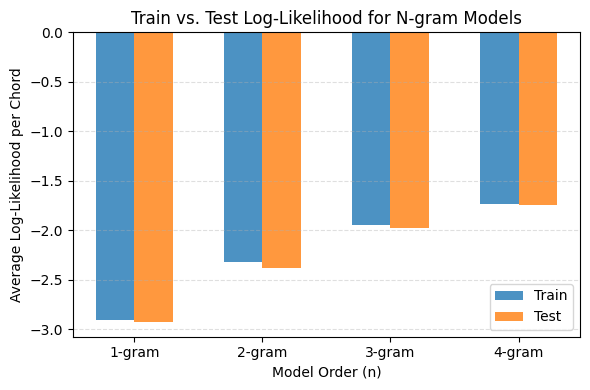

In [154]:
import matplotlib.pyplot as plt
import numpy as np

train_ll = [
    unigram_avg_ll,
    bigram_avg_ll,
    trigram_avg_ll,
    fourgram_avg_ll
]

test_ll = [
    unigram_avg_ll_test,
    bigram_avg_ll_test,
    trigram_avg_ll_test,
    fourgram_avg_ll_test
]

n_values = np.arange(1, 5)

# Bar plot
width = 0.3  # width of each bar
x = np.arange(len(n_values))

plt.figure(figsize=(6,4))

# train bars
plt.bar(x - width/2, train_ll, width, label="Train", alpha=0.8)

# test bars
plt.bar(x + width/2, test_ll, width, label="Test", alpha=0.8)

plt.xticks(x, [f"{i}-gram" for i in n_values])
plt.ylabel("Average Log-Likelihood per Chord")
plt.xlabel("Model Order (n)")
plt.title("Train vs. Test Log-Likelihood for N-gram Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
def top_k_accuracy_ngram(song, n, ngram_probs, k=5):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: DataFrame with index=evidence, columns=next chords
    # k: number of top predictions to consider
    
    correct = 0
    total = 0
    
    if len(song) < n:
        return 0.0
    
    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])
        
        target = song[t]
        
        try:
            prob_row = ngram_probs.loc[context]
            
            top_k_chords = prob_row.nlargest(k).index.tolist()
            
            if target in top_k_chords:
                correct += 1
            total += 1
            
        except KeyError:
            total += 1
    
    return correct / total if total > 0 else 0.0

In [ ]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=5):.4f}")